In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, normalize

from sklearn.decomposition import PCA
from pca import pca
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering


%matplotlib inline

In [3]:
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [4]:
#lets see the datatypes
df.info()

#we have both int and float, lets make all int float type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [5]:
#convert all int type to float
df[['Assault', 'UrbanPop']] = df[['Assault', 'UrbanPop']].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [6]:
#lets see what the data looks like other than we do not have NaN we might have some strange value
df['City'].sort_values().unique()
len(df['City'].sort_values().unique())
df['Murder'].sort_values().unique()
df['Assault'].sort_values().unique()
df['UrbanPop'].sort_values().unique()
df['Rape'].sort_values().unique()

#they all seem reasonable values

array([ 7.3,  7.8,  8.3,  9.3,  9.5, 10.8, 11.1, 11.2, 11.3, 12.8, 14.2,
       14.9, 15.6, 15.8, 16.1, 16.3, 16.4, 16.5, 17.1, 18. , 18.8, 19.5,
       20. , 20.2, 20.7, 21. , 21.2, 21.4, 22.2, 22.5, 22.9, 24. , 25.5,
       25.8, 26.1, 26.2, 26.9, 27.8, 28.2, 29.3, 31. , 31.9, 32.1, 35.1,
       38.7, 40.6, 44.5, 46. ])

In [7]:
#Tbe city column is full of state names, so lets rename it to 'State'
df.rename({'City': 'State'}, axis=1, inplace=True)
df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236.0,58.0,21.2
1,Alaska,10.0,263.0,48.0,44.5
2,Arizona,8.1,294.0,80.0,31.0
3,Arkansas,8.8,190.0,50.0,19.5
4,California,9.0,276.0,91.0,40.6


In [8]:
#lets see the statistical characteristics of our dataset
df.describe()
#as we can see there is a major difference between the mean of Assault and Rape,
#  which could skew the PCA as Assault is dominating

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


## Correlation Analysis

/tmp/ipykernel_4006/2306064611.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


Text(0.5, 1.0, 'Correlation Heatmap of US Arrests')

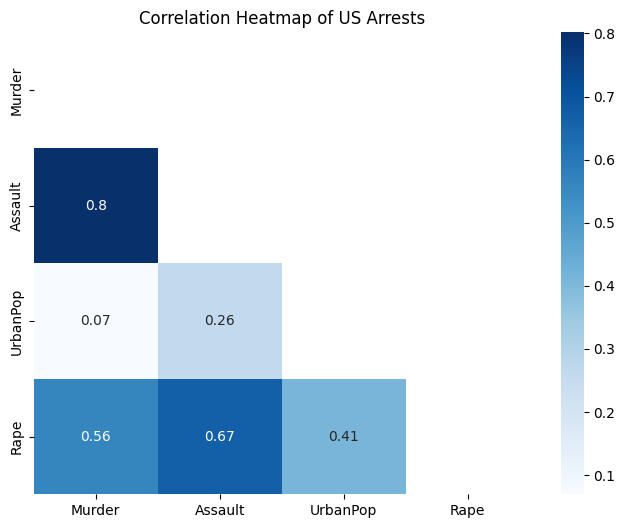

In [9]:
#First however lets see how the different features correlate to each other through a correlation matrix
plt.figure(figsize=(8,6))
df_corr = df.corr()

#clean the repetition on the heatmap we create to visualize the correlations
drop_upper = np.zeros_like(df_corr)
drop_upper[np.triu_indices_from(drop_upper)] = True

#plot the heatmap
sns.heatmap(df_corr, annot=True, mask=drop_upper, cmap='Blues')
plt.title('Correlation Heatmap of US Arrests')

#as we can see fromo the below Assault and Murder are strongly related to each other
#however murder and urban population are not correlated at all, which means that
#somebody is just as likely to get murdered in a small town as in a big city
#Urban popluation is somewhat related to rape cases however, although this could be 
#due to rapes being more under-reported in small towns as women and girls often feel
#ashamed of being raped and places where everybody knows them more likely keep them 
#away from reporting the assault, hence I feel it is somewhat inconclusive.
#Assault has more correlation to rape than murder does, which kind of makes sense 
#as failed rape would be reported as assault, but murder often times have very different
#motive in the background, a failed rape rarely become murder case and vica versa.

## Data Scaling

As discussed before, data scaling is important since the assault cases are significantly higher than murder or rape
cases. If left unscaled, the PCA result could be skewed.

In [10]:
#lets use the standard scaler from sklearn to transform our dataset so that we get 0 mean and 1 standard deviation
#to avoid bias in the evaluation of the PCA analysis
scaled = StandardScaler().fit_transform(df.iloc[:,1:5])

df_scaled = pd.DataFrame(scaled, columns=df.columns[1:5])
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


## PCA Analysis

Using PCA we can convert our variables to principal components and select the ones that are the most likey 
contributing to the outcome. 
We will look at the variance factor of our components and select the ones with the largest variance to make up 80-90% of the total. This depending on how correlated different variables are can give us a sizable reduction on the number of vaiables and
can speed up our algorithm.

In [11]:
#fitting our scaled dataframe to the PCA
arrest_pca = PCA().fit(df_scaled)

#we get the following variance ratios
variance_ratio = arrest_pca.explained_variance_ratio_
variance_ratio

#it seems that the first 2 components are dominating

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

Text(0, 0.5, 'Variance')

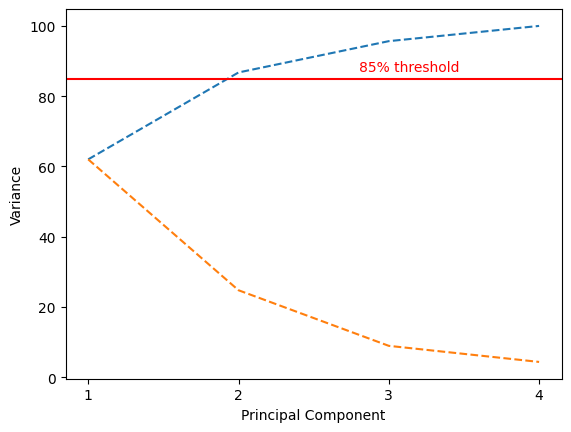

In [12]:
#lets plot the result to decide how many component we will work with
x = np.arange(1, len(variance_ratio)+1, 1)      #this is the x axis label vector

sns.lineplot(x=x, y=np.cumsum(variance_ratio)*100, linestyle='--', markers='o')
sns.lineplot(x=x, y=variance_ratio*100, linestyle='--', markers='o')
plt.xticks(x)
plt.axhline(y=85, color='r', linestyle='-')

#plot the threshold, which is 85% in this case
plt.text(2.8, 87, '85% threshold', color='red', fontsize=10)
plt.xlabel('Principal Component')
plt.ylabel('Variance')


#the 2 first principal component has crossed the 85% threshold, hence those are the ones we will rely on

In [14]:
#make the states to be the index on the df_scaled dataframe
df_scaled['State'] = df['State']
df_scaled.set_index('State', inplace=True)
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


In [15]:
#Now lets transform the dataset into a set of 2 variables using the PCA module

arrest_pca_model = pca(n_components=2)
arrest_pca_model.fit_transform(df_scaled)



[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


{'loadings':        Murder   Assault  UrbanPop      Rape
 PC1  0.535899  0.583184  0.278191  0.543432
 PC2  0.418181  0.187986 -0.872806 -0.167319,
 'PC':                      PC1       PC2
 Alabama         0.985566  1.133392
 Alaska          1.950138  1.073213
 Arizona         1.763164 -0.745957
 Arkansas       -0.141420  1.119797
 California      2.523980 -1.542934
 Colorado        1.514563 -0.987555
 Connecticut    -1.358647 -1.088928
 Delaware        0.047709 -0.325359
 Florida         3.013042  0.039229
 Georgia         1.639283  1.278942
 Hawaii         -0.912657 -1.570460
 Idaho          -1.639800  0.210973
 Illinois        1.378911 -0.681841
 Indiana        -0.505461 -0.151563
 Iowa           -2.253646 -0.104054
 Kansas         -0.796881 -0.270165
 Kentucky       -0.750859  0.958440
 Louisiana       1.564818  0.871055
 Maine          -2.396829  0.376392
 Maryland        1.763369  0.427655
 Massachusetts  -0.486166 -1.474496
 Michigan        2.108441 -0.155397
 Minnesota      -1

[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


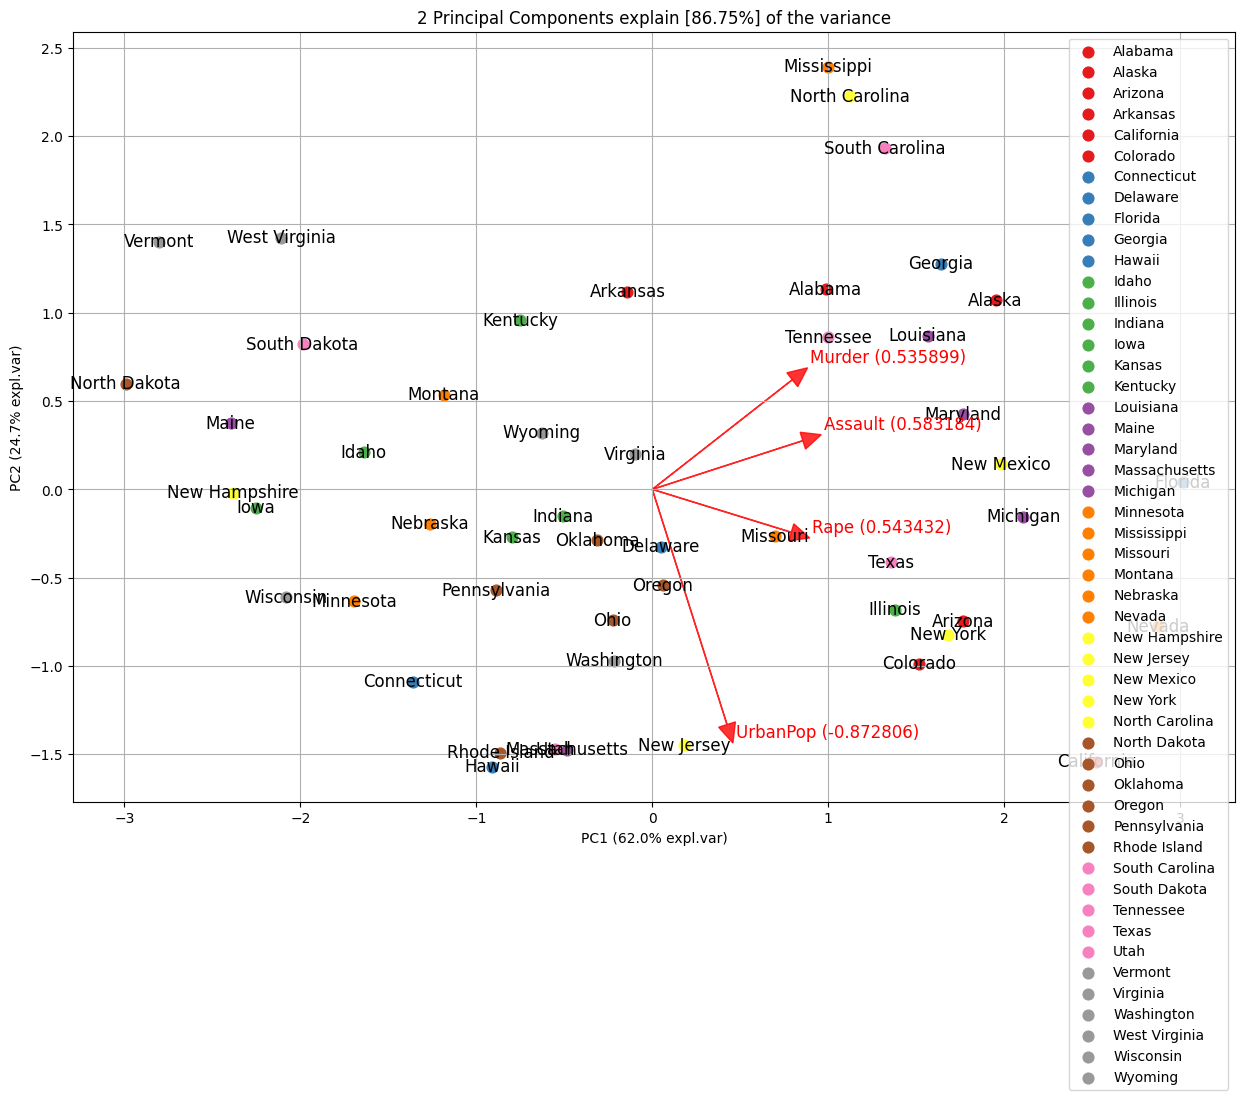

In [16]:
#lets visualize it on a biplot to make sense of it.

fig, ax = arrest_pca_model.biplot(n_feat=4,)

It is not clear how to cluster states from the above, but one of the way we could do is that some states are creating a high crime group Missuri, Illinois, Tennessee, Alabama on the border with Nevada, California and Florida being the hgihest in crime statistics in general.

## Hierachical Clustering

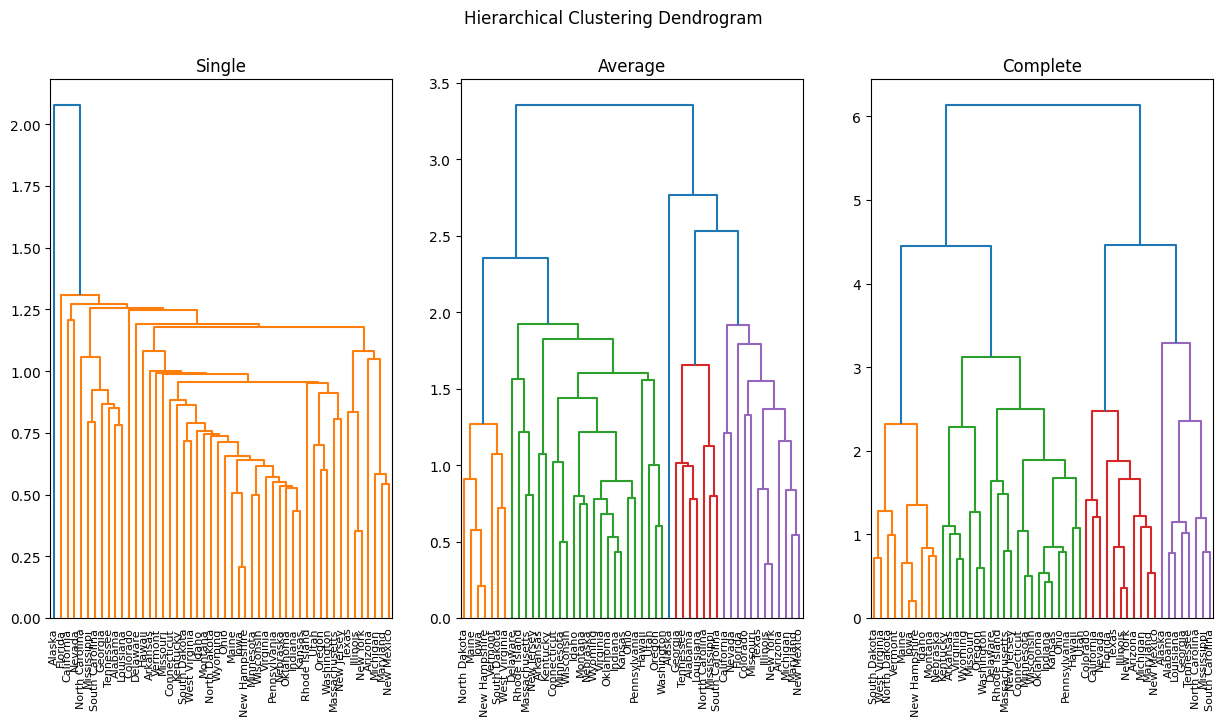

In [20]:
hierachical_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierachical_model = hierachical_model.fit(df_scaled)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(df_scaled, method='single'), labels=df_scaled.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(df_scaled, method='average'), labels=df_scaled.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(df_scaled, method='complete'), labels=df_scaled.index, ax=ax3)
plt.show()

It seems that the Complete method is the most balanced, so we will continue with that for the analysis.

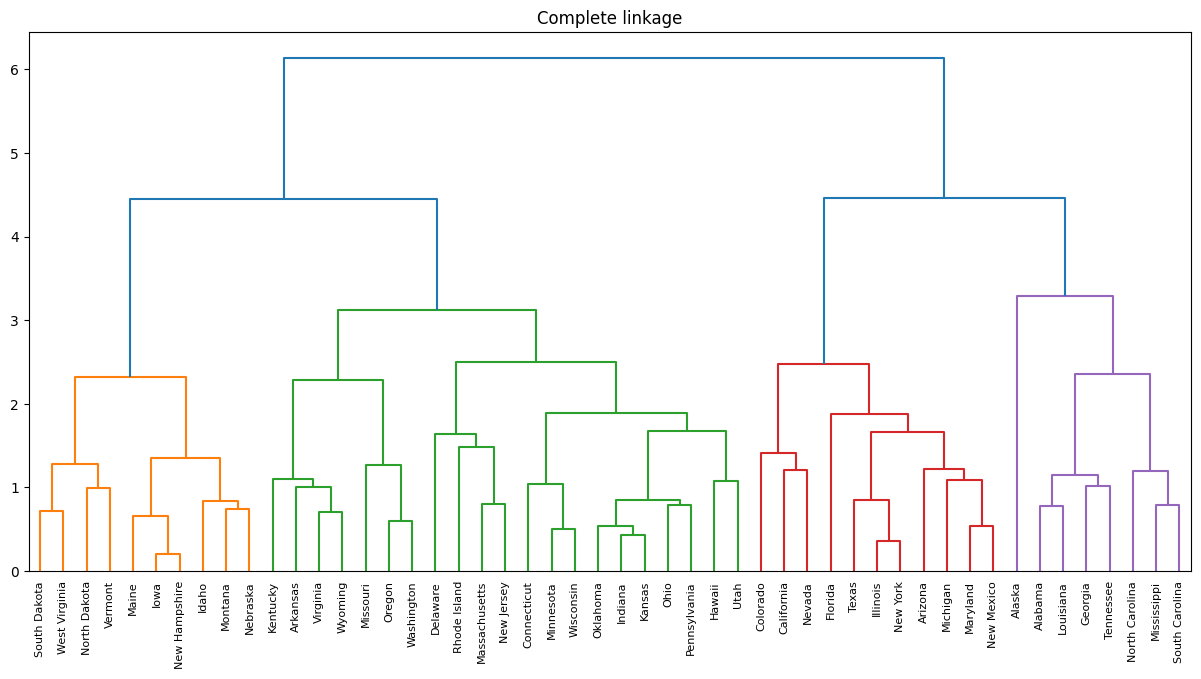

In [22]:
#lets plot the complete likage separately so that we can better see the variables
plt.figure(figsize=(15,7))
plt.title("Complete linkage")
dendrogram(linkage(df_scaled, method='complete'), labels=df_scaled.index)
plt.show()

THe hierachical clustering seem to have chategorized the states into groups of 
1. low crime and low urban population with orange
2. low crime and high urban population with green
3. high crime and low urban population with red and
4. high crime and high urban population with purple

## K-means Clustering

Due to the above hierachical clustering results, it seems to be a good idea to try to create 4 chategories

In [24]:
#first we need to create a PCA dataframe with n_components
pca_reduced = PCA(n_components=2).fit_transform(df_scaled)
df_pca_reduced = pd.DataFrame(pca_reduced, columns=['PCA1', 'PCA2'], index=df['State'].values)
df_pca_reduced

,PCA1,PCA2
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934
Colorado,1.514563,-0.987555
Connecticut,-1.358647,-1.088928
Delaware,0.047709,-0.325359
Florida,3.013042,0.039229
Georgia,1.639283,1.278942


/home/csaba/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


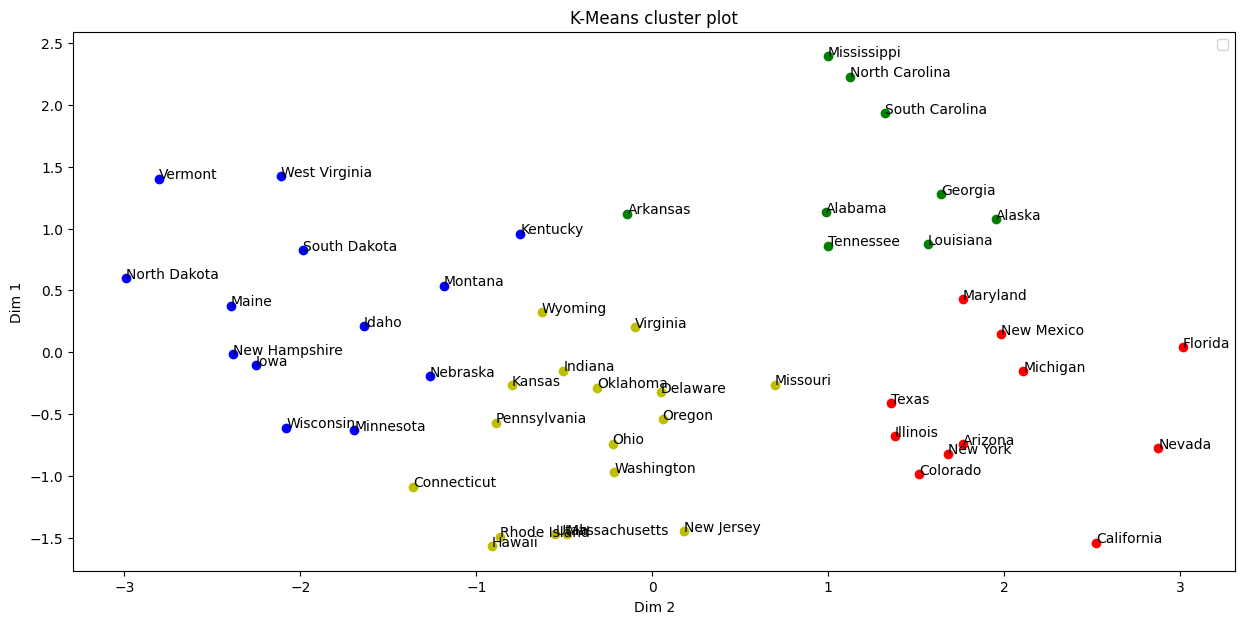

In [28]:


# We extract the first two components
x = df_pca_reduced['PCA1'].values.reshape(-1,1)
y = df_pca_reduced['PCA2'].values.reshape(-1,1)

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(df_pca_reduced)
cent = kmeans.cluster_centers_
countries = df_pca_reduced.index

# Plot clusters
fig, ax = plt.subplots(figsize=(15,7))
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = countries[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

The main difference between hierachical and K-means seems to be is hte placement of Arkansas which finds itself in between the low and high crime states and clustered differently based on different methods. Other than Arkansas, all ohter states seems to be consistently clustered with both methods.

In [30]:
df_pca_reduced['Label'] = cluster_labels
df_pca_reduced.head()

,PCA1,PCA2,Label
Alabama,0.985566,1.133392,2
Alaska,1.950138,1.073213,2
Arizona,1.763164,-0.745957,0
Arkansas,-0.141420,1.119797,2
California,2.523980,-1.542934,0


<AxesSubplot: xlabel='PCA1', ylabel='PCA2'>

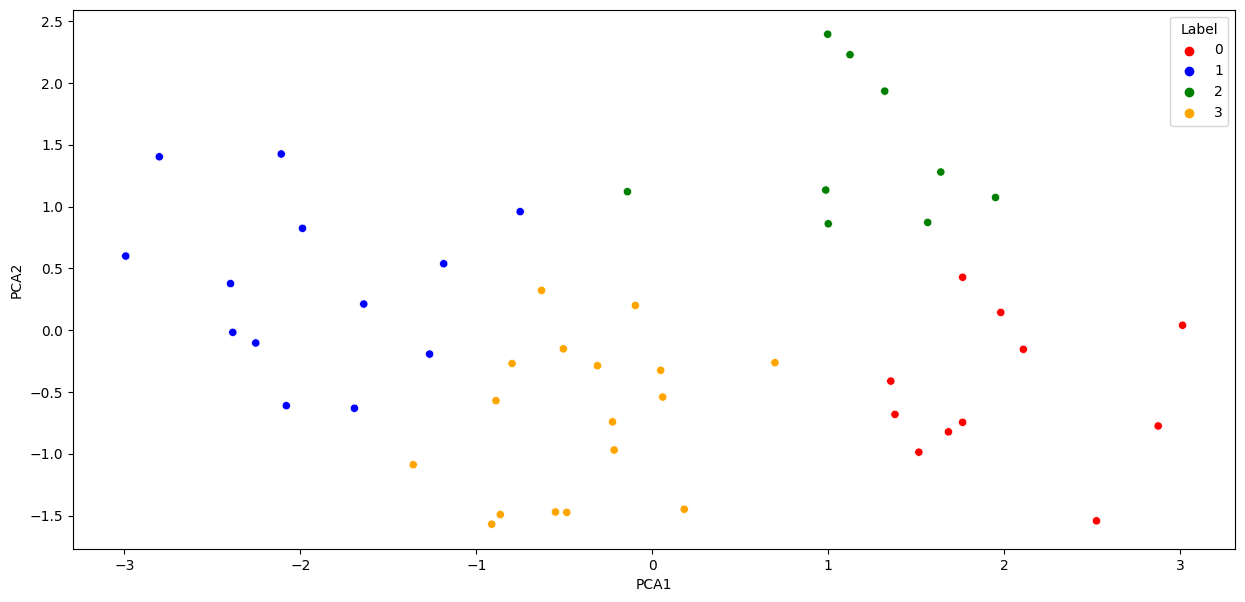

In [59]:

plt.figure(figsize=(15,7))
sns.scatterplot(df_pca_reduced, x='PCA1', y='PCA2', hue='Label', palette=['red', 'blue', 'green', 'orange'], sizes=30)